In [10]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")



In [11]:
from datetime import datetime, timedelta

def excel_to_datetime(excel_time):
    excel_epoch = datetime(1899, 12, 30)
    if excel_time < 61:
        excel_epoch = datetime(1899, 12, 31)
    return excel_epoch + timedelta(days=excel_time)

def load_data(dir):
    data_dict = {}
    if not os.path.exists(dir):
        raise FileExistsError(f"Directory not found.")
    for filename in os.listdir(dir):
        if filename.endswith('.csv'):
            filepath = os.path.join(dir, filename)
            df = pd.read_csv(filepath)
            cleaned_column = {col: col.strip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_column, inplace =True)

            if "time" in df.columns:
                df.rename(columns={"time":"datetime"}, inplace= True)
            if "Time" in df.columns:
                df.rename(columns={"Time":"datetime"}, inplace= True)
                
            df["datetime"] = df["datetime"].apply(excel_to_datetime)
            df.set_index("datetime", inplace= True)

            df = df.astype("float")
            data_dict[filename] = df
    return data_dict

In [12]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_block_missingness(series, n_blocks=2, block_size_fraction=0.05, seed=None):
    """Tạo các khối dữ liệu thiếu liên tiếp trên một Series."""
    series_with_missing = series.copy()
    if seed is not None:
        np.random.seed(seed)
    
    n_rows = len(series)
    block_size = int(n_rows * block_size_fraction)
    if block_size == 0: block_size = 1

    for _ in range(n_blocks):
        if n_rows > block_size:
            start_index = np.random.randint(0, n_rows - block_size)
            series_with_missing.iloc[start_index : start_index + block_size] = np.nan
            
    return series_with_missing

def create_missing_value(series, missing_fraction=0.05, seed=None):    
    series_with_missing = series.copy()
    if seed is not None:
        np.random.seed(seed)
    mask = np.random.rand(*series.shape) < missing_fraction
    series_with_missing = series_with_missing.mask(mask)
    
    return series_with_missing

def longest_notna(series):

    notna_mask = series.notna()
    group_id = (notna_mask != notna_mask.shift()).cumsum()
    notna_groups = group_id[notna_mask]
    
    if notna_groups.empty:
        return pd.Series(dtype=series.dtype, index=series.index) # Trả về series rỗng nhưng giữ index
        
    longest_group_id = notna_groups.value_counts().idxmax()
    return series[group_id == longest_group_id]

def knn_mean(series, n=4):
    ts = np.array(series, dtype=float) # Chuyển sang float để chứa NaN
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            lower = max(0, i - n)
            upper = min(len(ts), i + n + 1)
            neighbors = list(ts[lower:i]) + list(ts[i+1:upper])
            valid_neighbors = [x for x in neighbors if not np.isnan(x)]
            if valid_neighbors:
                out[i] = np.mean(valid_neighbors)
    # CHUẨN HÓA: Chuyển đổi mảng numpy kết quả trở lại thành Series với index ban đầu
    return pd.Series(out, index=series.index)

def seasonal_mean(series, season_lag, lr=1.0):
    out = series.copy()
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            seasonal_values = series.iloc[i % season_lag::season_lag].dropna()
            if not seasonal_values.empty:
                out.iloc[i] = seasonal_values.mean() * lr
    return out

def handle_missing(df, percent):
    # Remove columns have missing data above threshhold.
    missing_percent = df.isnull().mean()
    df_filtered = df.loc[:, missing_percent<percent]
    print(f"Filtered all features having missing value > 20%")
    print(f"Number of features removed: {len(df.columns)-len(df_filtered.columns)}")

    result_df = pd.DataFrame(columns = ["Feature","Method","Result"])

    # After filtered, dataframe now has only columns that can
    for col in df_filtered.columns:

        feature_data = df_filtered[[col]]
        ground_truth = longest_notna(feature_data)
        missing_df = create_missing_value(ground_truth)
        missing_df = create_block_missingness(missing_df)

        imputation_dict = {}
        imputation_dict["backward/forward_fill"] = missing_df.bfill().ffill()
        imputation_dict["linear_interpolation"] = missing_df.interpolate(method = 'linear', axis = 0, limit_direction = 'forward')
        imputation_dict["spline_interpolation"] = missing_df.interpolate(method = 'spline', order=3)        
        imputation_dict["quadaric_interpolation"] = missing_df.interpolate(method = 'cubicspline')
        imputation_dict["knn_mean"] = knn_mean(missing_df, 8)
        imputation_dict["seasonal_mean"] = seasonal_mean(missing_df[col], season_lag = 12, lr = 1.25)
        imputation_dict["linear_ffill"] = missing_df.interpolate(method='linear').ffill()
        imputation_dict["linear_bfill"] = missing_df.interpolate(method='linear').bfill()
        imputation_dict["spline_bfill_ffill"] = missing_df.interpolate(method='spline', order = 3).bfill().ffill()
        imputation_dict["seasonal_linear_ffill"] = seasonal_mean(missing_df[col], season_lag = 12, lr = 1.25).interpolate(method='linear').ffill()

        for key, pred_value in imputation_dict.items():
            if pd.isna(np.array(pred_value)).any():
                r2 = np.nan
            else:
                r2 = r2_score(ground_truth, pred_value)
            result_df.loc[len(result_df)]=[col,key,r2]
            
    best_methods_idx = result_df.groupby('Feature')['Result'].idxmax()
    best_methods_df = result_df.loc[best_methods_idx]
    print("Highest R² method per feature:")
    print(best_methods_df[['Feature', 'Method', 'Result']])


In [13]:
from sklearn.metrics import mean_squared_error


class TSImputer:
    
    def __init__(self, strategy = 'r2', verbose=True):
        if strategy not in ['r2', 'mae', 'mse']:
            raise ValueError("Strategy must be either 'r2' or 'mae'")
        self.strategy = strategy
        self.verbose = verbose
        self.best_methods = {} # Lưu trữ phương pháp tốt nhất cho mỗi cột
        self._define_pipelines()
        
    def _define_pipelines(self):

        self.pipelines = {
            "backward_forward_fill": lambda s: s.bfill().ffill(),
            "linear_interpolation": lambda s: s.interpolate(method='linear', limit_direction='both'),
            "spline_interpolation": lambda s: s.interpolate(method='spline', order=3, limit_direction='both'),
            "quadratic_interpolation": lambda s: s.interpolate(method='quadratic', limit_direction='both'),
            "knn_mean_k8": lambda s: knn_mean(s, n=8),
            "seasonal_mean_lag12": lambda s: seasonal_mean(s, season_lag=12, lr=1.0),
            "linear_bfill": lambda s: s.interpolate(method='linear').bfill(),
            "linear_ffill": lambda s: s.interpolate(method='spline', order=3).ffill(),
            "linear_then_fill_edges": lambda s: s.interpolate(method='linear').bfill().ffill(),
            "spline_then_fill_edges": lambda s: s.interpolate(method='spline', order=3).bfill().ffill(),
            "seasonal_then_linear": lambda s: seasonal_mean(s, season_lag=12, lr=1.0).interpolate(method='linear').bfill().ffill()
        }

        if self.verbose: 
            print(f"AutoImputer initialized with {len(self.pipelines)} methods to evaluate.")

    def fit(self, df: pd.DataFrame, threshold = 0.5):
        if self.verbose:
            print("\nStart find best imputation method")

        df_to_impute = df.loc[:, df.isna().mean() < threshold]
        for col in df_to_impute:

            if self.verbose:
                print(f"Evaluating columns: {col}")

            feature_data = df_to_impute[col]
            ground_truth = longest_notna(feature_data)

            if len(ground_truth) < 20: # Cần đủ dữ liệu để đánh giá
                    self.best_methods_[col] = "linear_then_fill_edges" # Default
                    if self.verbose: print(f"   -> Not enough clean data. Defaulting to 'linear_then_fill_edges'.")
                    continue

                # SỬA LỖI: Truyền Series vào hàm tạo dữ liệu thiếu
            missing_series = create_missing_value(ground_truth, missing_fraction=0.1)
            missing_series = create_block_missingness(missing_series, n_blocks=2)

            original_values = ground_truth[missing_series.isnull()]
            if original_values.empty:
                self.best_methods[col] = "backward/forward_fill" # Default
                if self.verbose: print(f"   -> Failed to create test gaps. Defaulting.")
                continue

            best_method = None # SỬA LỖI: Khởi tạo là None
            best_score = -np.inf if self.strategy == 'r2' else np.inf

            for name, method_func in self.pipelines.items():
                # SỬA LỖI: Truyền Series vào hàm imputation
                imputed_series = method_func(missing_series)
                imputed_values = imputed_series.loc[original_values.index]

                if imputed_values.isnull().any():
                    continue # Bỏ qua nếu phương pháp thất bại

                # Tính điểm trên DỮ LIỆU ĐÚNG
                current_score = 0
                if self.strategy == "r2":
                    current_score = r2_score(original_values, imputed_values)
                    if current_score > best_score:
                        best_score, best_method = current_score, name
                elif self.strategy == "mae":
                    current_score = mean_absolute_error(original_values, imputed_values)
                    if current_score < best_score:
                        best_score, best_method = current_score, name
                elif self.strategy == "mse":
                    current_score = mean_squared_error(original_values, imputed_values)
                    if current_score < best_score:
                        best_score, best_method = current_score, name

            # SỬA LỖI: Kiểm tra 'is not None' thay vì '!= np.nan'
            if best_method is not None:
                self.best_methods[col] = best_method
                if self.verbose:
                    print(f"   -> Best method found: '{best_method}' ({self.strategy.upper()}: {best_score:.4f})")
            else: 
                self.best_methods[col] = 'backward_forward_fill'
                if self.verbose:
                    print(f"   -> No suitable method found. Defaulting to 'backward_forward_fill'.")
        return self

    def transform(self, df):

        if not self.best_methods:
            raise RuntimeError("You must use 'fit()' before calling 'transform()' ")
        if self.verbose:
            print("\nStarting apply best methods...")
        
        new_df = df.copy()

        for col, method in self.best_methods.items():
            if col in new_df.columns:
                if self.verbose:
                    print(f"Apply '{method}' to column '{col}'")

                pipeline_func = self.pipelines[method]
                new_df[col] = pipeline_func(new_df[col])

        return new_df
    
    def fit_transform(self, df, threshold=0.5):

        self.fit(df, threshold)
        return self.transform(df)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
class TSFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformer để tạo các đặc trưng thời gian và đặc trưng trễ.
    """
    def __init__(self, date_features, lag_config):
        self.date_features = date_features
        self.lag_config = lag_config # Dictionary: {'col_name': [lag1, lag2]}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()

        if 'day_of_week' in self.date_features:
            X_['day_of_year'] = X_.index.dayofyear
        
        # Tạo đặc trưng trễ dựa trên cấu hình
        for col, lags in self.lag_config.items():
            if col in X_.columns:
                for lag in lags:
                    X_[f'{col}_lag_{lag}'] = X_[col].shift(lag)
        return X_


    

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss

class StationaryTester(BaseEstimator, TransformerMixin):
    def __init__(self, method = 'adf', significant_level = 0.1, verbose = True):
        if method not in ['adf','kpss']:
            raise ValueError("Error: This version only support ADF and KPSS test.")
        self.method = method
        self.significant_level = significant_level
        self.verbose = verbose
        self.stationary_features = []
        self.non_stationary_features = []

    def run_adf_test(self, series):
        result = adfuller(series.dropna())
        return result[1]
        
    def run_kpss_test(self, series):
        result = kpss(series.dropna(), regression='c', nlags="auto")
        return result[1]
    
    def fit(self, X, y = None):
        if self.verbose:
            print(f"Running stationarity test using '{self.method.upper()}' method with alpha={self.significant_level}...")
        
        self.stationary_features = []
        self.non_stationary_features = []

        for col in X.columns:
            series = X[col]
            p_value = -1

            if self.method == 'adf':
                p_value = self.run_adf_test(series)
                # ADF: p-value thấp (< alpha) => Dừng
                if p_value <= self.significant_level:
                    self.stationary_features.append(col)
                    if self.verbose:
                        print(f"- Column '{col}': p-value={p_value:.4f}. Stationary (Reject H0).")
                else:
                    self.non_stationary_features.append(col)
                    if self.verbose:
                        print(f"- Column '{col}': p-value={p_value:.4f}. Non-Stationary (Fail to Reject H0).")

            elif self.method == 'kpss':
                p_value = self.run_kpss_test(series)
                # KPSS: p-value thấp (< alpha) => Không Dừng
                if p_value <= self.significant_level:
                    self.non_stationary_features.append(col)
                    if self.verbose:
                        print(f"- Column '{col}': p-value={p_value:.4f}. Non-Stationary (Reject H0).")
                else:
                    self.stationary_features.append(col)
                    if self.verbose:
                        print(f"- Column '{col}': p-value={p_value:.4f}. Stationary (Fail to Reject H0).")
        
        return self
    
    def transform(self, X):
        """
        Trả về một DataFrame mới chỉ chứa các cột đã được xác định là dừng.
        """
        if not self.stationary_features and not self.non_stationary_features:
            raise RuntimeError("You must run 'fit()' before calling 'transform()'")
        
        return X[self.stationary_features]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
class GrangerFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,target_variable, max_lag=4, significant_level = 0.1, verbose = True):
        self.target_variable = target_variable
        self.max_lag = max_lag
        self.significant_level = significant_level
        self.verbose = verbose

        self.selected_features = []

    def fit(self, X, y = None):
        if self.target_variable not in X.columns:
            raise ValueError(f"Target variable '{self.target_variable}' not found in input DataFrame.")
        
        df = X.copy()
        
        if self.verbose:
            print("Checking stationarity of all features in DataFrame...")
        
        stationarity_tester = StationaryTester(method='adf', significant_level=self.significant_level, verbose=False)
        stationarity_tester.fit(df)
        
        non_stationary_cols = stationarity_tester.non_stationary_features

        if non_stationary_cols:
            if self.verbose:
                print(f"Non-stationarity detected: {non_stationary_cols}")
                print("Apply differencing...")
            # Áp dụng sai phân cho TOÀN BỘ dataframe để giữ nguyên mối quan hệ
            df_stationary = df.diff().dropna()
        else:
            if self.verbose:
                print("All features are stationary.")
            df_stationary = df.dropna()

        target_series = df_stationary[self.target_variable]
        feature_columns = df_stationary.columns.drop(self.target_variable)
        
        non_stationary_cols = stationarity_tester.non_stationary_features

        if self.verbose:
            print(f"\n--- Bước 2: Chạy kiểm định Granger cho {len(feature_columns)} features ---")
            
        self.selected_features_ = []
        for col in feature_columns:
            combined_series = df_stationary[[self.target_variable, col]]
            
            try:
                test_result = grangercausalitytests(combined_series, maxlag=self.max_lag, verbose=False)
                
                # Kiểm tra xem có lag nào có p-value đủ nhỏ không
                is_causal = False
                for lag in range(1, self.max_lag + 1):
                    p_value = test_result[lag][0]['ssr_ftest'][1]
                    if p_value < self.significant_level:
                        is_causal = True
                        break # Chỉ cần một lag thỏa mãn là đủ
                
                if is_causal:
                    self.selected_features.append(col)
                    if self.verbose:
                        print(f"- Feature '{col}' CÓ quan hệ nhân quả Granger (p < {self.significant_level}).")
                # else:
                #     if self.verbose:
                #         print(f"- Feature '{col}' KHÔNG có quan hệ nhân quả Granger.")

            except Exception as e:
                # Bỏ qua nếu có lỗi (ví dụ: chuỗi có phương sai bằng 0)
                if self.verbose:
                    print(f"Không thể chạy kiểm định cho '{col}'. Lỗi: {e}. Bỏ qua.")

        if self.verbose:
            print(f"\nĐã chọn được {len(self.selected_features)} features: {self.selected_features}")
            
        return self
    
    def transform(self, X):
        """
        Lọc DataFrame đầu vào, chỉ giữ lại các đặc trưng đã chọn và cột mục tiêu.
        """
        if not self.selected_features:
            raise RuntimeError("You must run 'fit()' before calling 'transform()'")
        
        # Luôn giữ lại cột mục tiêu
        features_to_keep = self.selected_features + [self.target_variable]
        
        # Lọc ra các cột không tồn tại trong X (phòng trường hợp)
        features_to_keep = [f for f in features_to_keep if f in X.columns]
        
        return X[features_to_keep]
        

In [17]:
class DifferencingTransformer(BaseEstimator, TransformerMixin):
    """
    Một transformer để lấy sai phân các cột được chỉ định và giữ nguyên các cột khác.
    """
    def __init__(self, cols_to_diff=None, cols_to_keep=None):
        self.cols_to_diff = cols_to_diff if cols_to_diff is not None else []
        self.cols_to_keep = cols_to_keep if cols_to_keep is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_new = pd.DataFrame(index=X.index)
        
        # Lấy sai phân các cột cần thiết
        for col in self.cols_to_diff:
            if col in X.columns:
                df_new[f'{col}_diff'] = X[col].diff()
        
        # Giữ nguyên các cột khác
        for col in self.cols_to_keep:
            if col in X.columns:
                df_new[col] = X[col]
                
        return df_new

In [22]:
DATA_PATH = '../Dataset'
GREENHOUSE_TEAM = "Digilog"

team_folder_path = os.path.join(DATA_PATH,GREENHOUSE_TEAM)
team_df = load_data(team_folder_path)

print(f"Successfully loaded data from {GREENHOUSE_TEAM}")
autoImp = TSImputer()

df_elec = team_df["GreenhouseClimate.csv"][["assim_vip","int_blue_vip", "int_red_vip","int_farred_vip", "int_white_vip"]]
df_elec.loc[df_elec['assim_vip'] == 0, ['int_blue_vip', 'int_red_vip', 'int_farred_vip', 'int_white_vip']] = 0
imputed_df = autoImp.fit_transform(df_elec)
imputed_df = imputed_df.dropna(axis = 1)
imputed_df

Successfully loaded data from Digilog
AutoImputer initialized with 11 methods to evaluate.

Start find best imputation method
Evaluating columns: assim_vip
   -> Best method found: 'spline_interpolation' (R2: 0.2832)
Evaluating columns: int_blue_vip
   -> Best method found: 'backward_forward_fill' (R2: 1.0000)
Evaluating columns: int_red_vip
   -> Best method found: 'backward_forward_fill' (R2: 1.0000)
Evaluating columns: int_farred_vip
   -> Best method found: 'backward_forward_fill' (R2: 1.0000)
Evaluating columns: int_white_vip
   -> Best method found: 'backward_forward_fill' (R2: 1.0000)

Starting apply best methods...
Apply 'spline_interpolation' to column 'assim_vip'
Apply 'backward_forward_fill' to column 'int_blue_vip'
Apply 'backward_forward_fill' to column 'int_red_vip'
Apply 'backward_forward_fill' to column 'int_farred_vip'
Apply 'backward_forward_fill' to column 'int_white_vip'


,assim_vip,int_blue_vip,int_red_vip,int_farred_vip,int_white_vip
datetime,,,,,
2019-12-16 00:00:00.000,0.000000,0.0,0.0,0.0,0.0
2019-12-16 00:04:59.808,0.000000,0.0,0.0,0.0,0.0
2019-12-16 00:09:59.616,0.000000,0.0,0.0,0.0,0.0
2019-12-16 00:15:00.288,0.000000,0.0,0.0,0.0,0.0
2019-12-16 00:20:00.096,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-05-29 23:39:59.904,0.000000,0.0,0.0,0.0,0.0
2020-05-29 23:44:59.712,0.000000,0.0,0.0,0.0,0.0
2020-05-29 23:50:00.384,0.000000,0.0,0.0,0.0,0.0


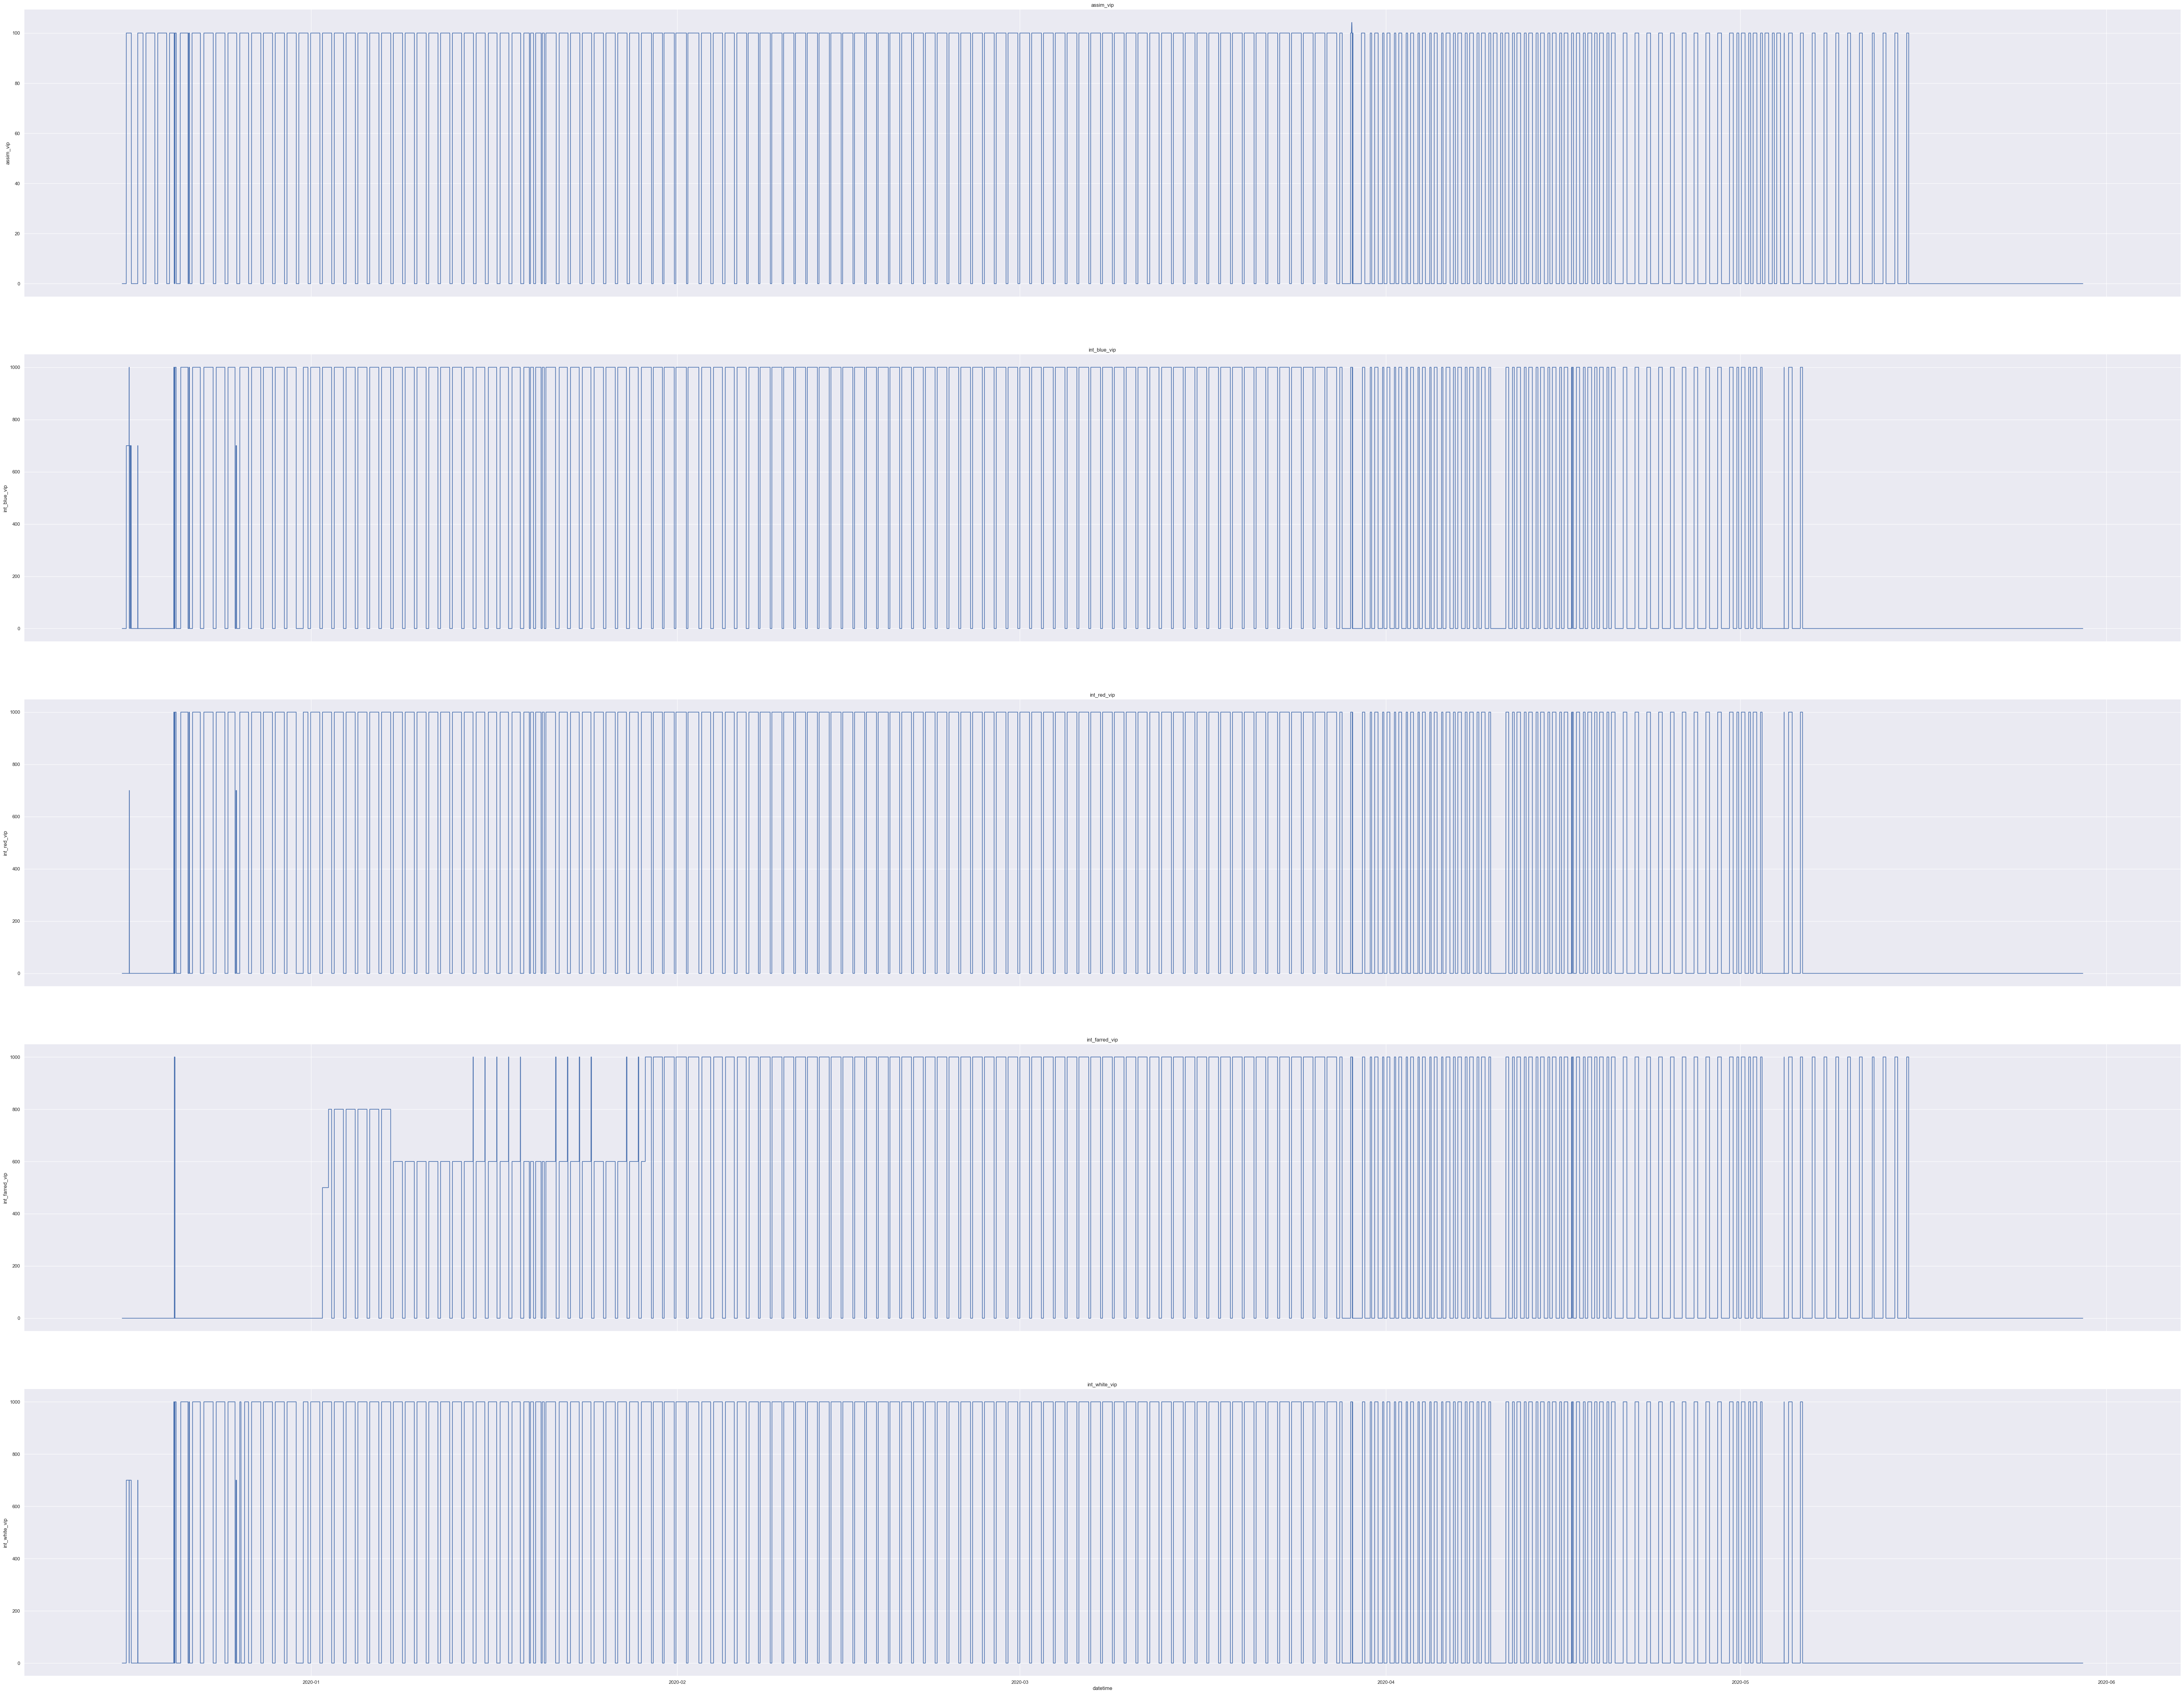

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
def plot_feature(df):
    features_df = df.copy()
    fig, axes = plt.subplots(nrows = 5 , ncols = 1, figsize=(90,70), sharex= True)
    for i, column in enumerate(features_df.columns):
            sns.lineplot(x="datetime", y=column, data=features_df, ax=axes[i])
            axes[i].set_title(column)
plot_feature(imputed_df)

In [ ]:
POWER_CONSTANTS = {
    'HPS': 81.0,      # W/m2
    'LED_BLUE': 7.27,   # W/m2
    'LED_RED': 25.3,    # W/m2
    'LED_FARRED': 6.23, # W/m2
    'LED_WHITE': 22.72  # W/m2
}

imputed_df['power_w_m2'] = (
    (imputed_df['assim_vip'] / 100) * POWER_CONSTANTS['HPS'] +
    (imputed_df['int_blue_vip'] / 1000) * POWER_CONSTANTS['LED_BLUE'] +
    (imputed_df['int_red_vip'] / 1000) * POWER_CONSTANTS['LED_RED'] +
    (imputed_df['int_farred_vip'] / 1000) * POWER_CONSTANTS['LED_FARRED'] +
    (imputed_df['int_white_vip'] / 1000) * POWER_CONSTANTS['LED_WHITE']
)

minutes_per_interval = 5
imputed_df['energy_wh_m2'] = imputed_df['power_w_m2'] * (minutes_per_interval / 60)

is_high_period = (imputed_df.index.hour >= 7) & (imputed_df.index.hour < 23)
imputed_df['period'] = np.where(is_high_period, 'High', 'Low')

daily_energy_wh = imputed_df.groupby([imputed_df.index.date, 'period'])['energy_wh_m2'].sum()

calculated_results = daily_energy_wh.unstack(level='period').fillna(0)
calculated_results['ElecHigh'] = calculated_results['High'] / 1000
calculated_results['ElecLow'] = calculated_results['Low'] / 1000

target_df = team_df["Resources.csv"][["ElecHigh","ElecLow"]]
calculated_results
x1 = target_df["ElecHigh"]
x2 = calculated_results["ElecHigh"].drop(calculated_results.index[-1])

x3 = target_df["ElecLow"]
x4 = calculated_results["ElecLow"].drop(calculated_results.index[-1])

print(f"R2 ElecHigh: {r2_score(x1,x2)}")
print(f"R2 ElecLOW: {r2_score(x3,x4)}")





R2 ElecHigh: 0.9845902238126178
R2 ElecLOW: 0.9800771469703805


In [ ]:

daily_data = imputed_df.resample('D').agg(["sum"])
daily_data.columns = ["_".join(col) if isinstance(col, tuple) else col for col in daily_data.columns]
daily_data

,AssimLight_sum,BlackScr_sum,CO2air_sum,Cum_irr_sum,EC_drain_PC_sum,EnScr_sum,HumDef_sum,PipeGrow_sum,PipeLow_sum,Rhair_sum,...,t_heat_sp_sum,t_heat_vip_sum,t_vent_sp_sum,t_ventlee_vip_sum,t_ventwind_vip_sum,water_sup_sum,water_sup_intervals_sp_min_sum,water_sup_intervals_vip_min_sum,window_pos_lee_sp_sum,window_pos_lee_vip_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-16,12300.000000,10554.0,156920.0,7.4,547.2,13559.0,1725.1,11781.3,5931.5,19362.9,...,5177.846154,5460.0,6052.104545,6339.9,6513.9,98.0,288000.0,288000.0,345.6,345.6
2019-12-17,13000.000000,0.0,192406.0,0.0,547.2,11556.0,988.2,0.0,2637.6,22467.6,...,4862.453846,4559.8,5137.145455,4847.6,4917.6,0.0,113550.0,115520.0,345.6,345.6
2019-12-18,21800.000000,10493.0,184315.0,0.0,547.2,11535.0,1232.6,0.0,3167.9,20808.7,...,4755.650000,4750.4,5050.050000,5042.0,5047.3,0.0,61620.0,59660.0,345.6,345.6
2019-12-19,21800.000000,10493.0,177663.0,0.0,547.2,10835.0,1096.1,0.0,186.5,21526.0,...,4283.300000,4598.3,4751.750000,4890.3,4890.3,0.0,170890.0,121400.0,345.6,345.6
2019-12-20,17600.000000,19633.0,190225.0,58.8,562.1,9045.0,1647.4,0.0,8579.5,20015.0,...,4443.700000,4483.7,5987.000000,5929.1,5929.1,733.0,308650.0,286580.0,121.2,141.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26,0.000000,9664.0,138158.0,623.2,1707.6,10245.0,1342.3,11506.0,207.4,24621.3,...,6336.000000,6336.0,9792.000000,9792.0,9792.0,7203.0,321420.0,321420.0,0.0,0.0
2020-05-27,0.000000,9664.0,133619.0,646.0,1894.3,10230.0,1322.0,11495.5,0.0,24654.6,...,6336.000000,6336.0,9792.000000,9792.0,9792.0,7437.0,321420.0,321420.0,0.0,0.0
2020-05-28,0.000000,9684.0,134175.0,624.9,2046.3,10230.0,1565.0,11502.9,348.4,23942.4,...,6336.000000,6336.0,9792.000000,9792.0,9792.0,7219.0,321420.0,321420.0,0.0,0.0


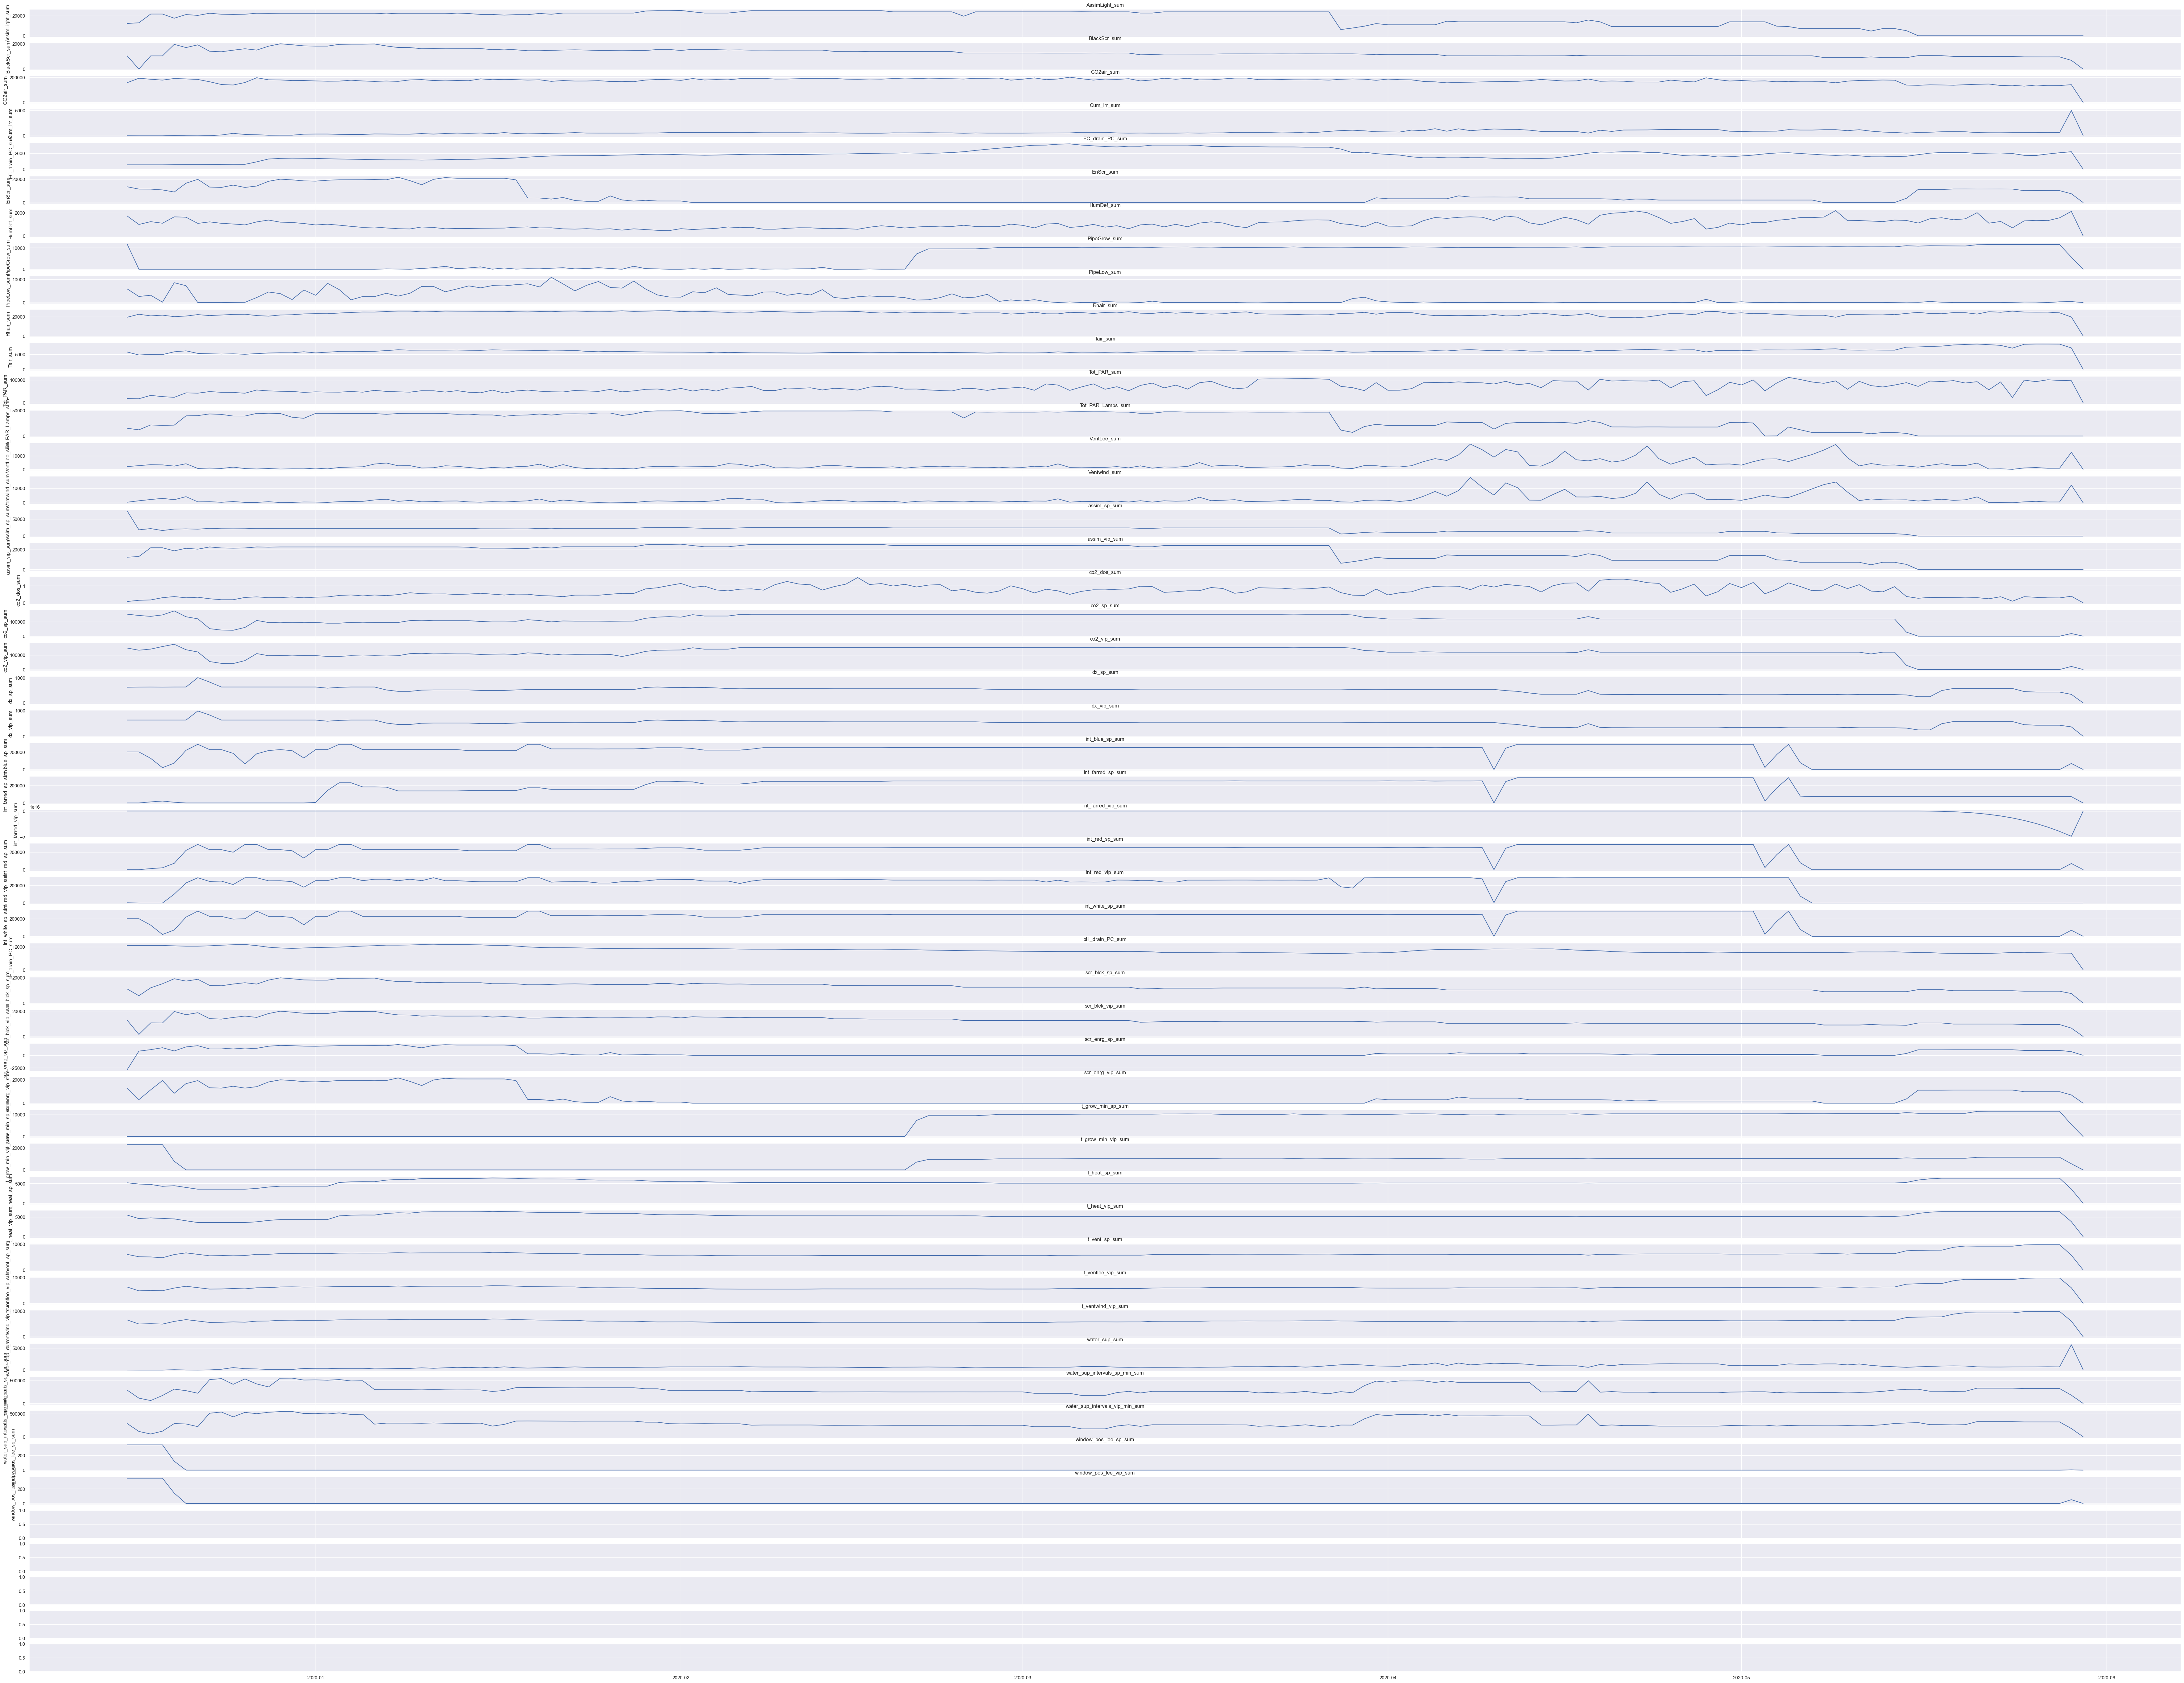

In [63]:
plot_feature(daily_data)

In [71]:

target_df = team_df["Resources.csv"][["ElecHigh","ElecLow","Heat_cons"]]

weather_df = team_df["Weather.csv"]

full_df = target_df.join(daily_data).join(weather_df)

differencer = DifferencingTransformer(
    cols_to_diff=['Heat_cons', 'ElecHigh', 'ElecLow', 'Tout', 'Tair', 'Iglob', 'PipeLow', 'PipeGrow', 'Rhair'],
    cols_to_keep=['t_heat_sp_sum', 'int_blue_sp_sum', 'int_red_sp_sum', 
                  'int_farred_sp_sum', 'int_white_sp_sum']
)

lag_config = {
    'Heat_cons_diff': [1, 2, 3],
    'ElecHigh_diff': [1, 2, 3],
    'ElecLow_diff': [1, 2, 3],
    'Tair_diff': [1, 2, 3],
    'Tout_diff': [1, 2, 3]
}


preprocessing_pipeline = Pipeline([
    ('differencer', differencer),
    ('feature_engineer', TSFeatureEngineer(date_features=['day_of_year'], lag_config=lag_config))
])

processed_df = preprocessing_pipeline.fit_transform(full_df)
# processed_df.head()
selected_df = processed_df.dropna()
X = selected_df[['t_heat_sp_sum', 'int_blue_sp_sum', 'int_red_sp_sum', 
                  'int_farred_sp_sum', 'int_white_sp_sum']]
y = selected_df["ElecHigh_diff"]

split_idx = int(len(X) * 0.3)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Kích thước X_train: {X_train.shape}, Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_test: {X_test.shape}, Kích thước y_test: {y_test.shape}")




Kích thước X_train: (48, 5), Kích thước y_train: (48,)
Kích thước X_test: (114, 5), Kích thước y_test: (114,)


In [65]:
X

,t_heat_sp_sum,int_blue_sp_sum,int_red_sp_sum,int_farred_sp_sum,int_white_sp_sum
datetime,,,,,
2019-12-20,4443.7,74000.0,73000.0,8000.0,73000.0
2019-12-21,4000.5,220000.0,220000.0,0.0,220000.0
2019-12-22,3564.0,288000.0,288000.0,0.0,288000.0
2019-12-23,3564.0,228000.0,228000.0,0.0,228000.0
2019-12-24,3564.0,228000.0,228000.0,0.0,228000.0
...,...,...,...,...,...
2020-05-25,6336.0,0.0,0.0,72000.0,0.0
2020-05-26,6336.0,0.0,0.0,72000.0,0.0
2020-05-27,6336.0,0.0,0.0,72000.0,0.0


In [49]:
y

datetime
2019-12-20   -0.190667
2019-12-21    0.531583
2019-12-22    0.003167
2019-12-23    0.201333
2019-12-24   -0.065333
                ...   
2020-05-25    0.000000
2020-05-26    0.000000
2020-05-27    0.000000
2020-05-28    0.000000
2020-05-29    0.000000
Name: ElecHigh_diff, Length: 162, dtype: float64

In [50]:

# autoFE = TSFeatureEngineer(target_columns=None,
#     lags=(1,7),
#     window_sizes=[3],
#     date_features_to_create=['month', 'dayofweek', 'quarter'],
#     interactions=[])
# daily_data = imputed_df.resample('D').agg(["mean"]).dropna()
# daily_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in daily_data.columns]
# featured_df = autoFE.fit_transform(daily_data)

# weather_df = team_df["Weather.csv"].drop(columns=["Iglob"])

# target_df = team_df["Resources.csv"][["ElecHigh","ElecLow","Heat_cons"]]
# # target_df["target"] = (target_df["ElecHigh"]*0.08 + target_df["ElecLow"]*0.04 + target_df["Heat_cons"]*0.0083) * 62.5
# target_df["target"] = target_df["ElecHigh"]
# target_df = target_df.drop(columns=["ElecHigh","ElecLow","Heat_cons"])

# full_df = target_df.join(featured_df).join(weather_df)

# full_df["target"] = full_df["target"].diff()

# full_df = full_df.dropna(axis = 0)





In [51]:
# # stationary_test = StationaryTester(method='kpss', significant_level=0.05)
# # result = stationary_test.fit(full_df)

# granger_test = GrangerFeatureSelection(target_variable='target', max_lag=3, verbose=True, significant_level=0.06)
# selected_df = granger_test.fit_transform(full_df)
# # selected_df = selected_df.drop(columns="target")
# selected_df

In [52]:
# for lag in range(1,8):
#     selected_df[f'target_lag_{lag}'] = selected_df["target"].shift(lag)

# selected_df = selected_df.dropna()
# X = selected_df.drop(columns="target")
# y = selected_df["target"]

# split_idx = int(len(X) * 0.8)
# X_train, X_test = X[:split_idx], X[split_idx:]
# y_train, y_test = y[:split_idx], y[split_idx:]

# print(f"Kích thước X_train: {X_train.shape}, Kích thước y_train: {y_train.shape}")
# print(f"Kích thước X_test: {X_test.shape}, Kích thước y_test: {y_test.shape}")

In [72]:
from sklearn.preprocessing import StandardScaler

# Khởi tạo StandardScaler
scaler = StandardScaler()

# Khớp scaler trên dữ liệu huấn luyện và biến đổi nó
X_train_scaled = scaler.fit_transform(X_train)

# Biến đổi dữ liệu kiểm tra bằng scaler đã được khớp
X_test_scaled = scaler.transform(X_test)

# In ra kích thước của các tập dữ liệu đã được chia tỷ lệ
print(f"Kích thước X_train_scaled: {X_train_scaled.shape}")
print(f"Kích thước X_test_scaled: {X_test_scaled.shape}")

Kích thước X_train_scaled: (48, 5)
Kích thước X_test_scaled: (114, 5)


<Axes: xlabel='datetime'>

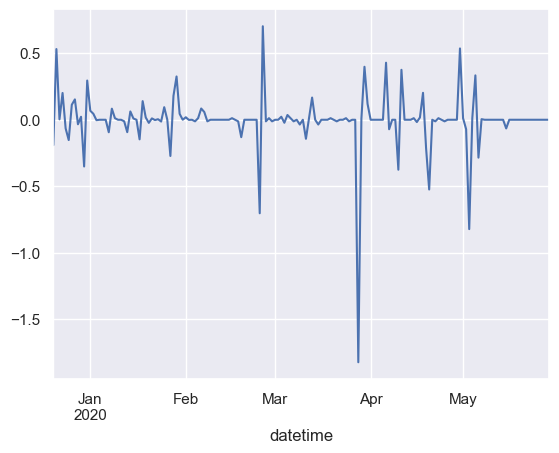

In [73]:
y.plot()

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import lightgbm as lgb
fs_model = RandomForestRegressor(n_estimators=200, random_state=42)
fs_model.fit(X_train_scaled, y_train)

cb_model = CatBoostRegressor(iterations=1000, 
                                random_state=42, 
                                verbose=0)
cb_model.fit(X_train_scaled, y_train)

lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_scaled, y_train)

y_pred = fs_model.predict(X_test_scaled)
y_pred_cb = cb_model.predict(X_test_scaled)
y_pred_lgb = lgbm.predict(X_test_scaled)

# Tính và in ra R2 score
r2 = r2_score(y_test, y_pred)
r2_cb = r2_score(y_test, y_pred_cb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"Model Accuracy RF: {r2:.4f}")
print(f"Model Accuracy CB: {r2_cb:.4f}")
print(f"Model Accuracy LGB: {r2_lgb:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 5
[LightGBM] [Info] Start training from score -0.003966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes